# 1. Business Understanding

## 1.1 Objective
Predict survival on the Titanic

## 1.2 Description
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.


**Think about the reasons for the survival of passengers and predict whether the passengers in the test set will survive?**

[Description from Kaggle's Titanic competition](https://www.kaggle.com/c/titanic)

# 2. Data Understanding

## 2.1 Import Libraries

First, We need to import necessary python libraries which will be used in this project. 

In [15]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plot
import seaborn as sns

# Modelling Algorithms
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [16]:
# Setting plot
plot.rcParams.update({ 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
})



## 2.2 Review the data
Observe the data distribution and plot the visualization to observe the relationship between variables and survival.

(891, 12)


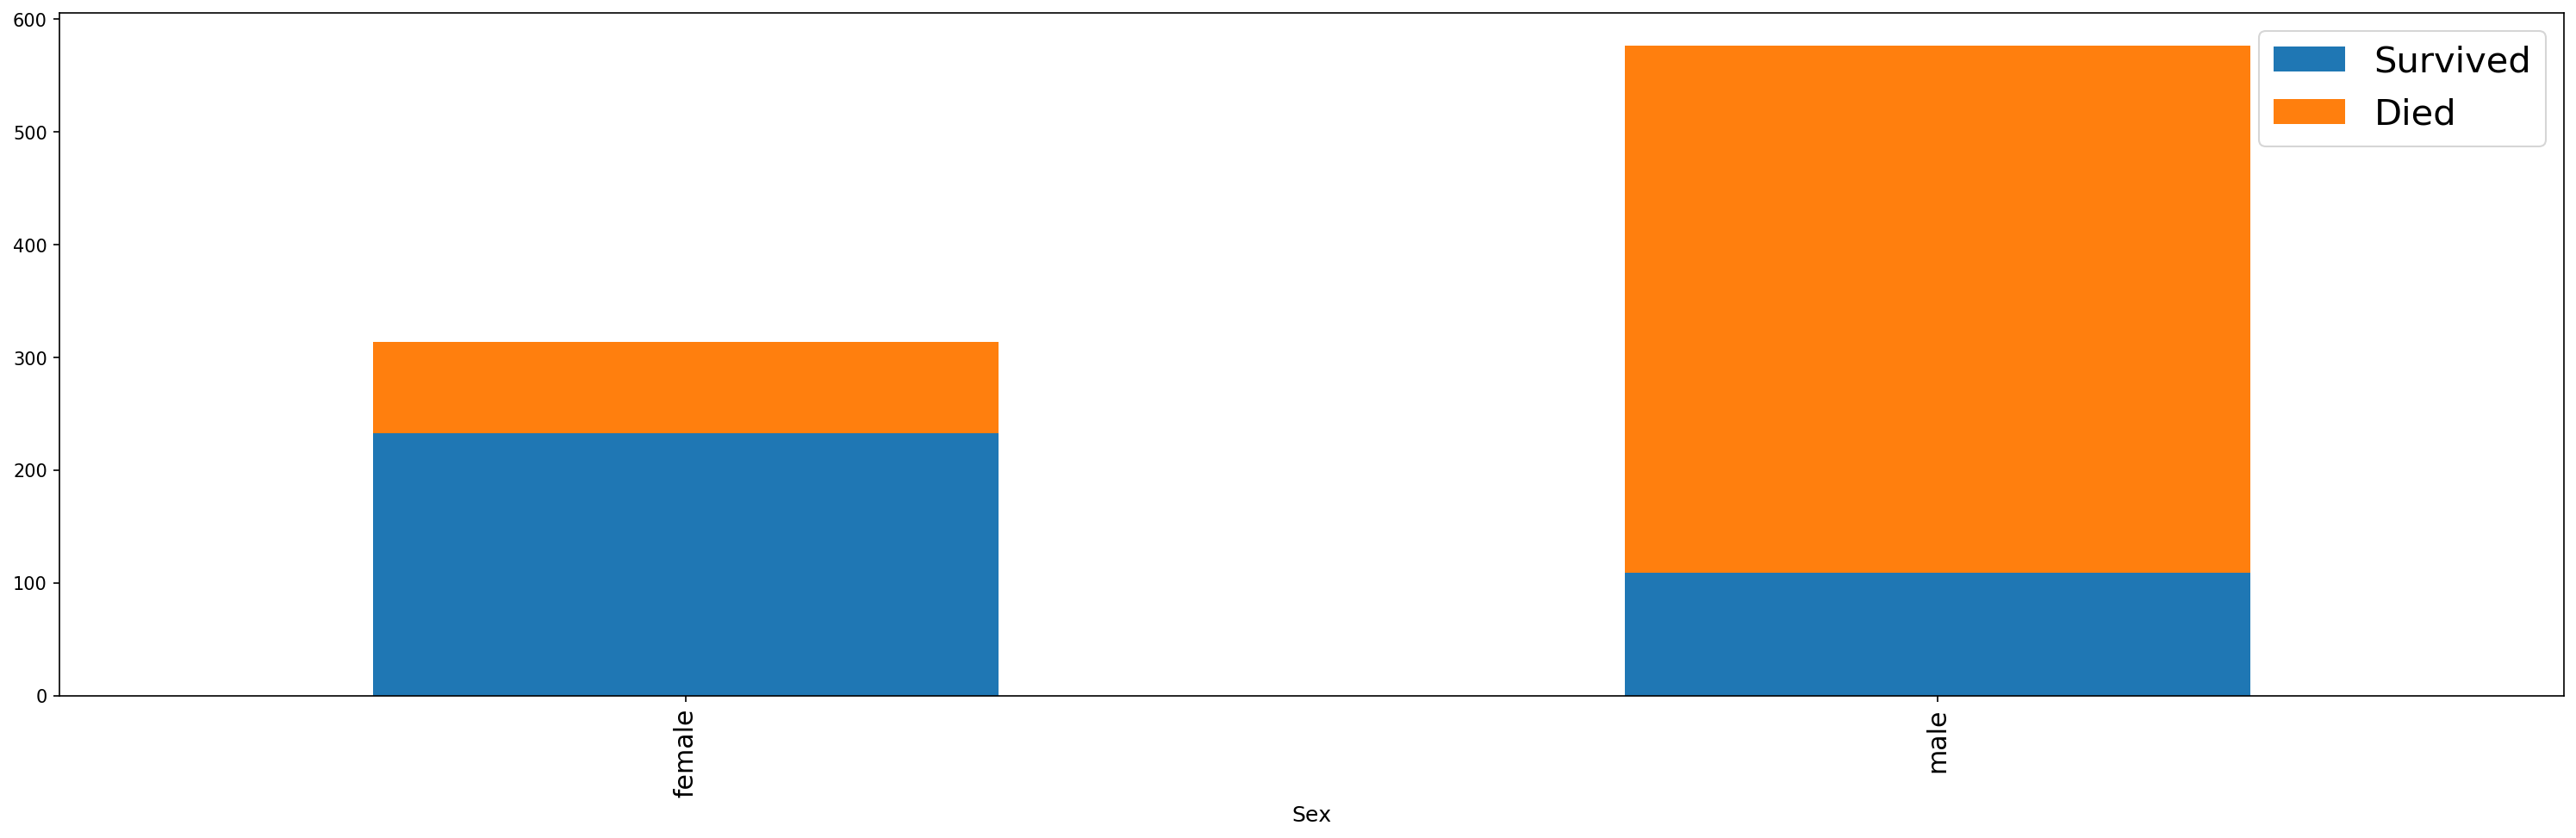

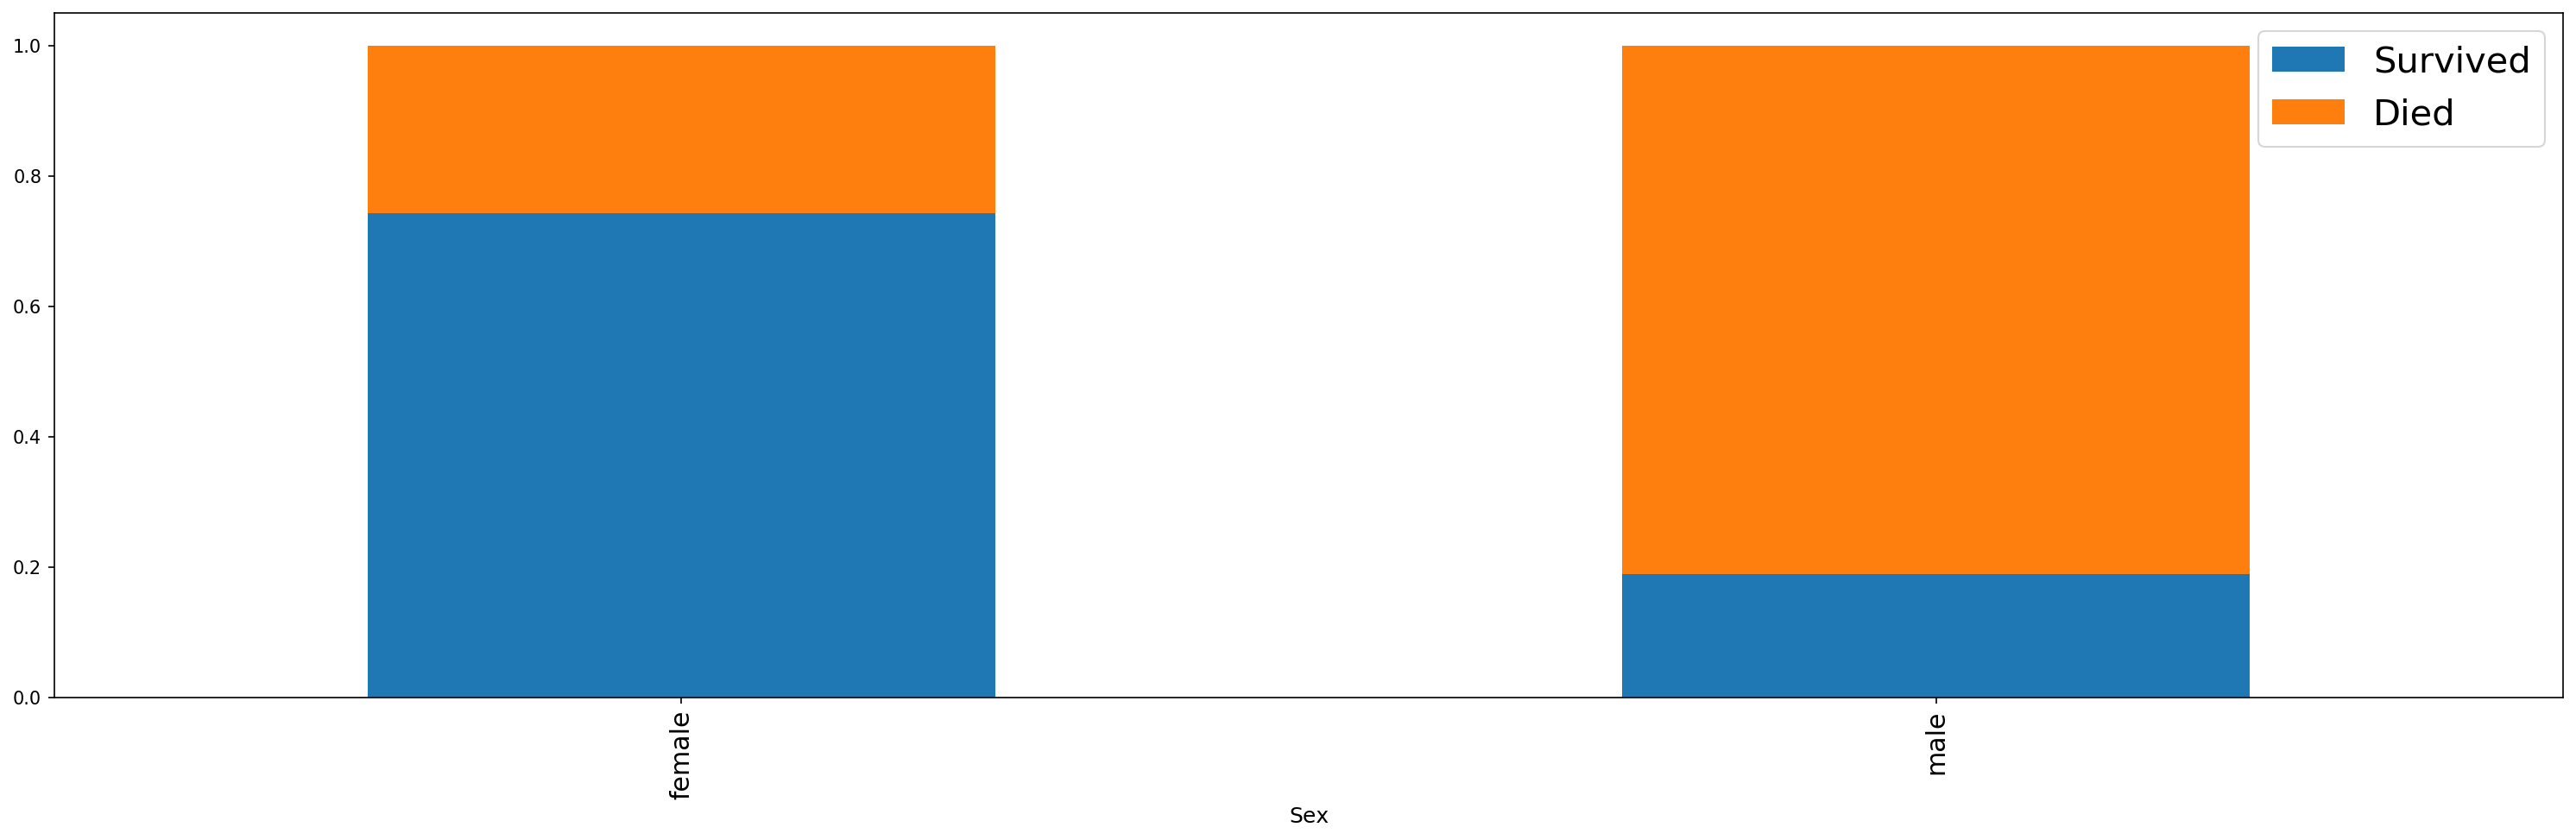

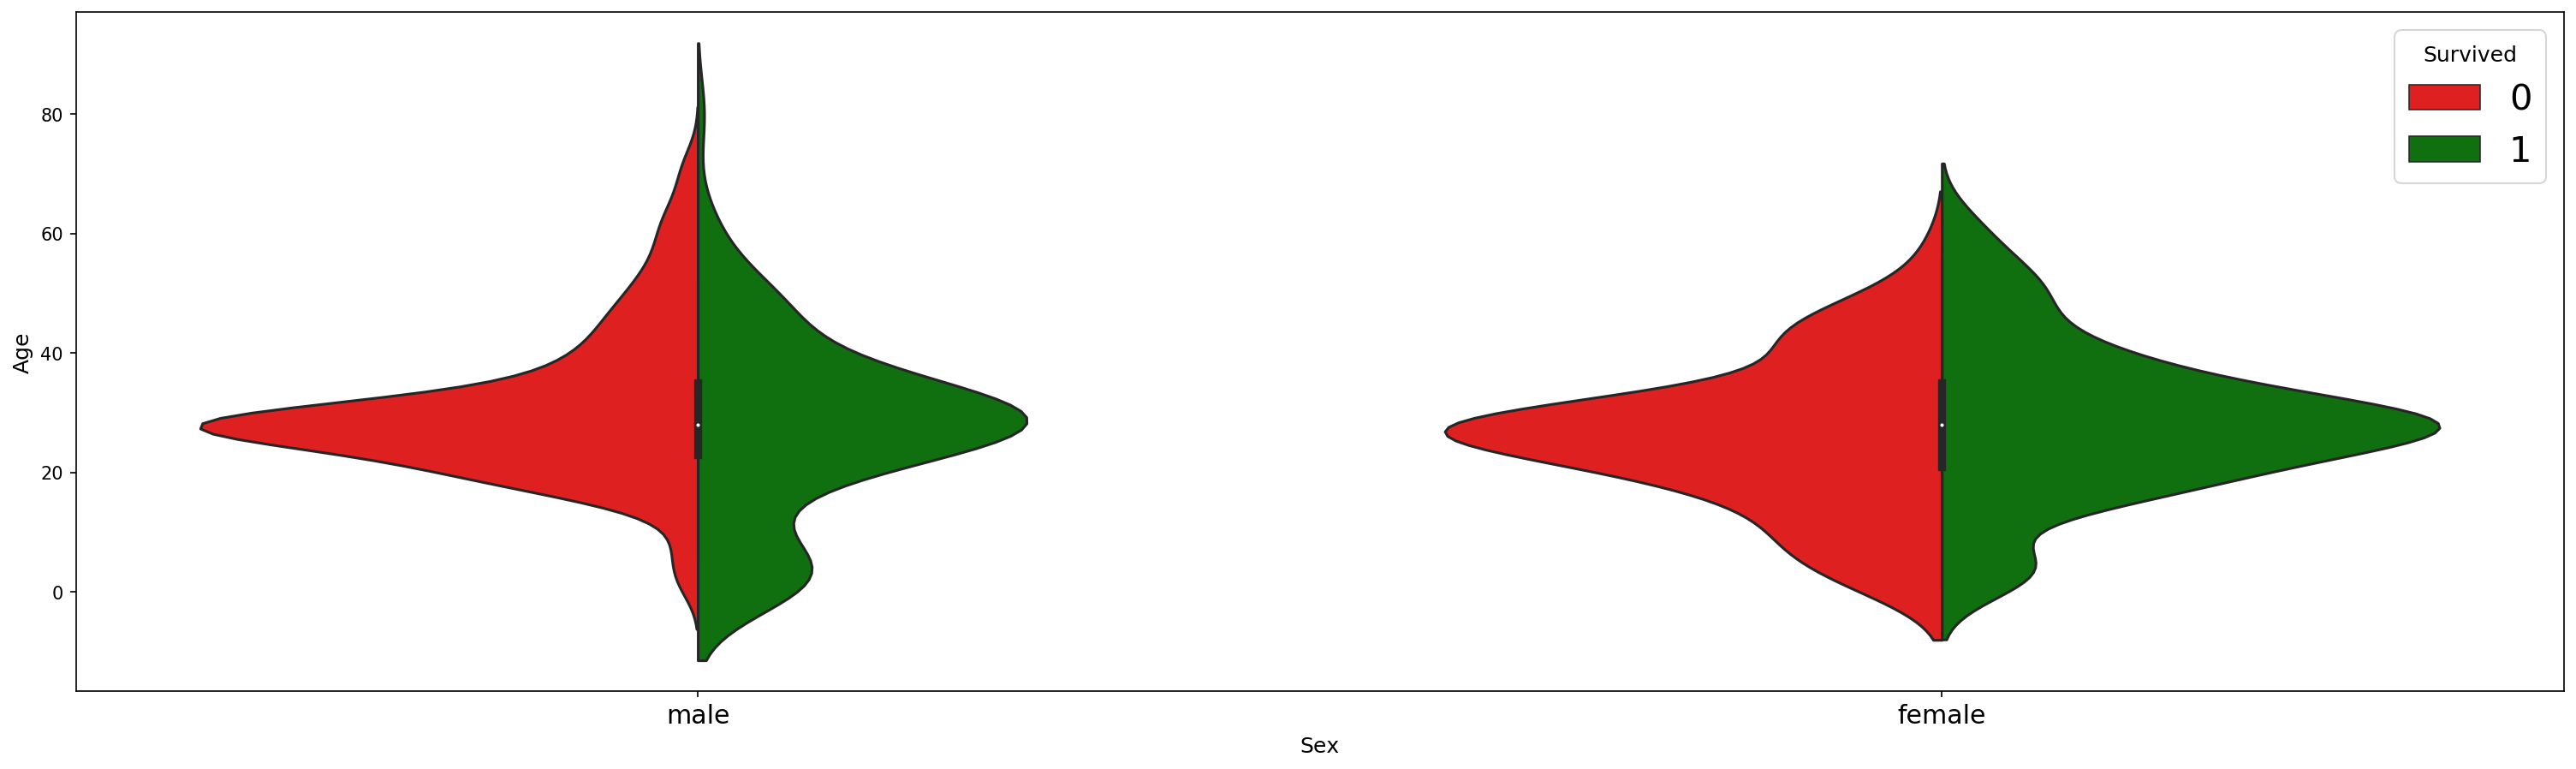

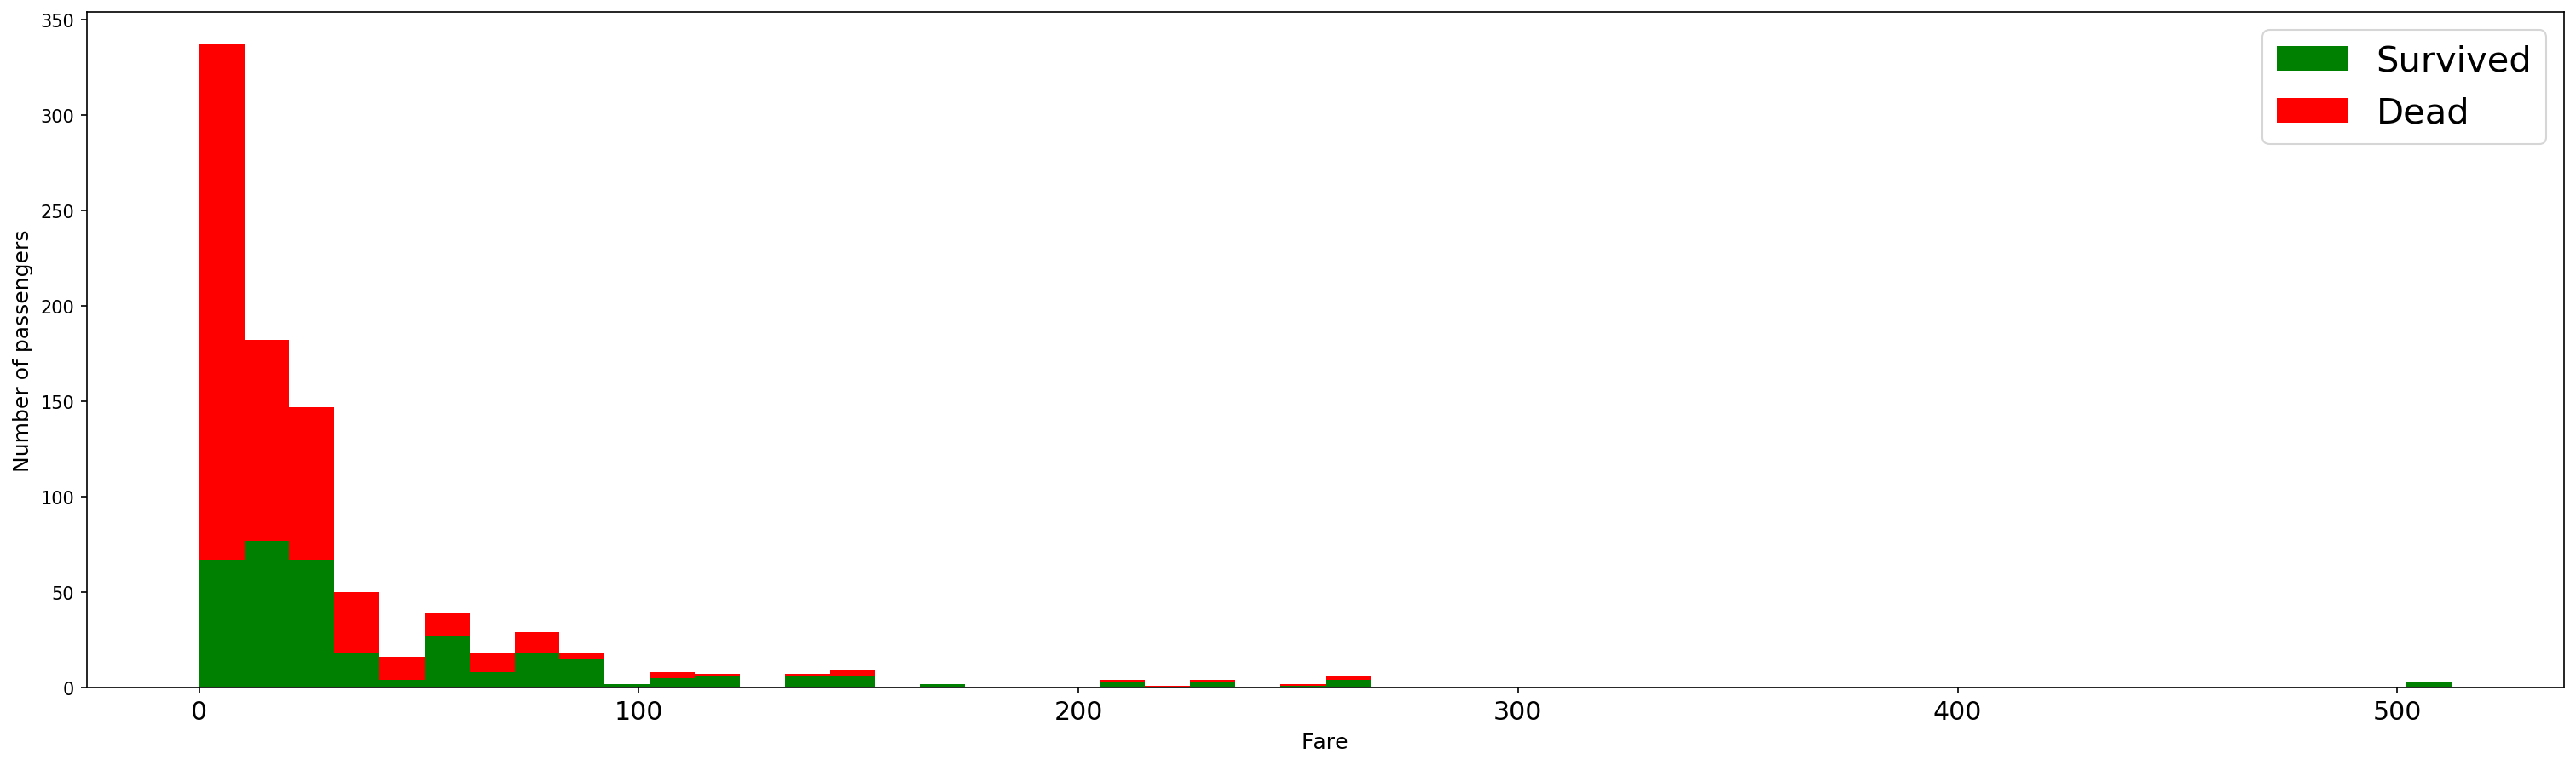

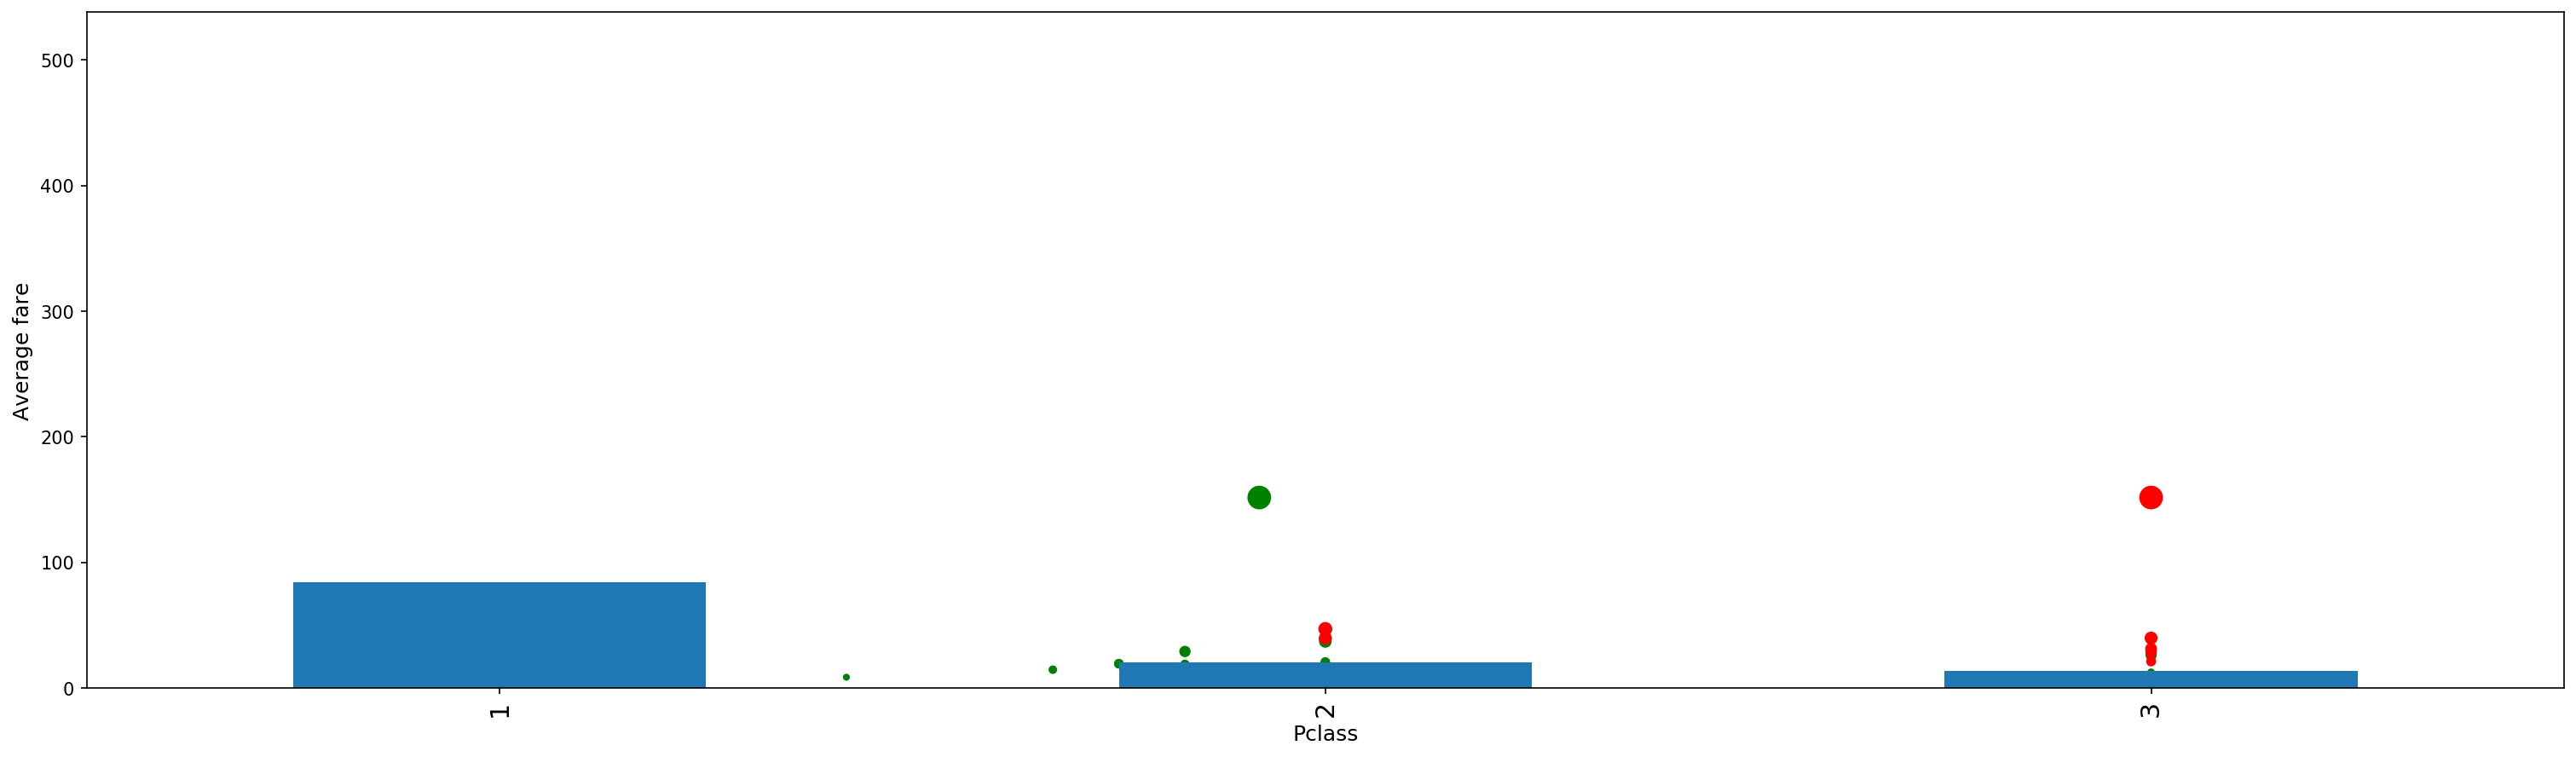

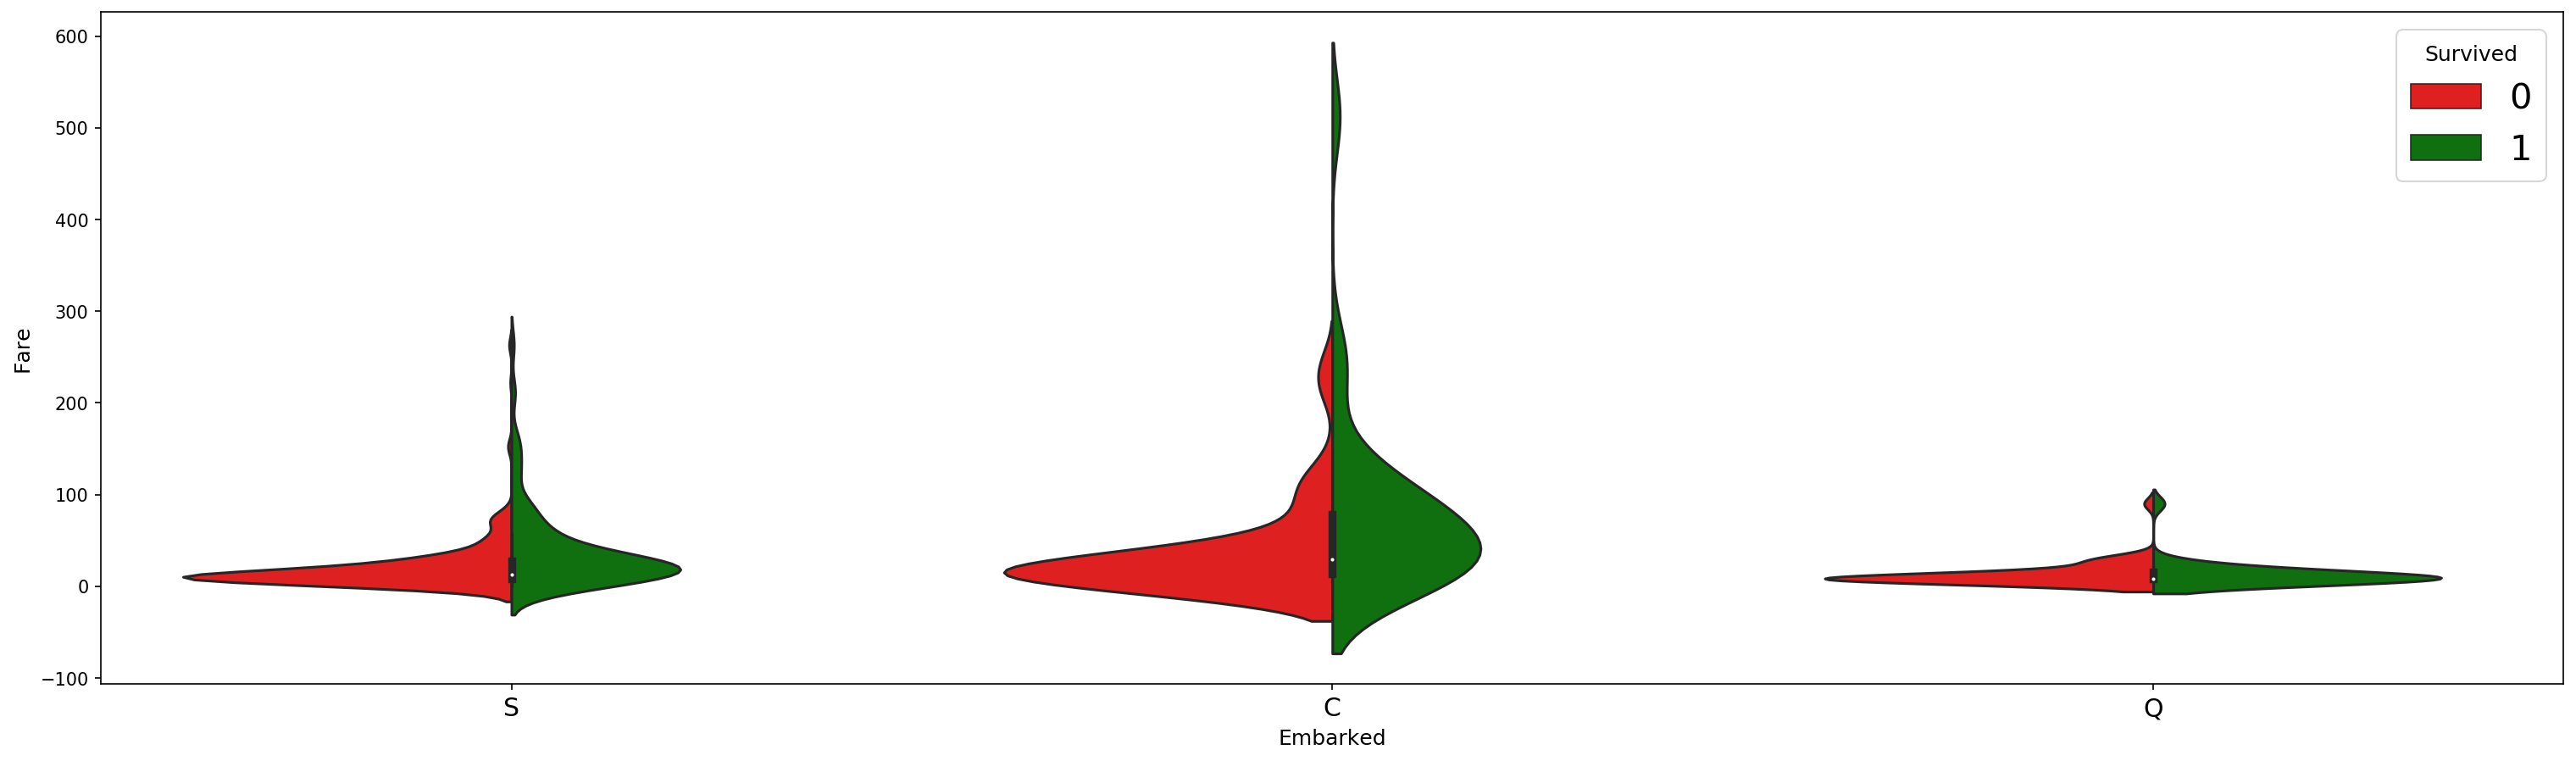

In [17]:
data = pd.read_csv('../titanic/train.csv')
print(data.shape)
#(891, 12)

data.head()
data.describe()

data['Age'] = data['Age'].fillna(data['Age'].median())

data['Died'] = 1 - data['Survived']
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), stacked=True);
data.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), stacked=True);


fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=data, 
               split=True,
               palette={0: "r", 1: "g"}
              );

figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], stacked=True, color=['g','r'],
         bins = 50, label = ['Survived', 'Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], 
           c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], 
           c='red', s=data[data['Survived'] == 0]['Fare']);

ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7), ax = ax);

fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data, split=True, palette={0: "r", 1: "g"});


## 2.3 Feature Engineering

In the previous section, we find some correlation between survival and attributes.

This part will show how to transfor and process these attributes for manageable.
And, the part also creates the additional features that will be useful in establishing the model.

For clarity, the code be breaked in separate functions.

#### First define a function to determine whether the feature has been processed

In [35]:
def status(feature):
    print('Processing', feature, ': done')

#### Loading Data

The train and test dataset will be loaded.
And, they will be combined for the future feature engineering.


In [58]:
def get_combined_data():
    train = pd.read_csv('../titanic/train.csv')
    test = pd.read_csv('../titanic/test.csv')
    
    targets = train.Survived
    train.drop(['Survived'], 1, inplace = True)
    
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace = True, axis=1)
    
    return combined

combined = get_combined_data()
print(combined.shape)
combined.head()

(1309, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Review the titles of passenger

In [59]:
titles = set()
for name in data['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

print(titles)

{'Master', 'Lady', 'Mlle', 'Rev', 'Mme', 'Sir', 'Major', 'Mrs', 'Col', 'Capt', 'Miss', 'Mr', 'Jonkheer', 'Dr', 'Ms', 'Don', 'the Countess'}


#### Set similar names to the same name

In [60]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)
    status('Title')
    return combined

#### Convert the title of dataset

In [61]:
combined = get_titles()
combined.head()

Processing Title : done


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


#### Check the null value of testset
The train set and test set may have information that another dataset does not have

In [62]:
combined[combined['Title'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,NaN


#### Deal with "Ages"
They saw in the first part that the Age variable resulted in 177 values. It more than 10% of dataset. Replacing them with mediam or average age of all passenger probably not be the great solution, because age may vary depending on the group and category of passengers.

In [63]:
print(combined.iloc[:891].Age.isnull().sum())
# null value of age attribute in train set

177


In [64]:
print(combined.iloc[891:].Age.isnull().sum())
# null value of age attribute in test set

86


Group the data set by gender, title, and passenger category, and calculate the median age for each subset.

In [65]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


Fill up the missing value of age based on different attributes

In [66]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return combined


combined = process_age()

Processing age : done


Use the title column to instead the name column

In [67]:
def process_names():
    global combined
    # we clean the Name variable
    combined.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    # removing the title variable
    combined.drop('Title', axis=1, inplace=True)
    
    status('names')
    return combined

combined = process_names()

combined.head()

Processing names : done


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


#### Dear with "Fares"

In [68]:
def process_fares():
    global combined
    combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace = True)
    status('fare')
    return combined

combined = process_fares()

Processing fare : done


#### Deal with "Embarked"

In [69]:
def process_embarked():
    global combined
    combined.Embarked.fillna('S', inplace = True)
    
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix = 'Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis = 1, inplace=True)
    status('embarked')
    return combined

combined = process_embarked()

combined.head()

Processing embarked : done


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


#### Deal with "Cabin"

In [70]:
train_cabin, test_cabin = set(), set()

for c in combined.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')

for c in combined.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')

print(train_cabin)

print(test_cabin)

{'E', 'D', 'G', 'A', 'U', 'T', 'F', 'B', 'C'}
{'E', 'D', 'G', 'A', 'U', 'F', 'B', 'C'}


In [71]:
def process_cabin():
    global combined
    
    combined.Cabin.fillna('U', inplace=True)
    
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix = 'Cabin')
    combined = pd.concat([combined, cabin_dummies], axis=1)
    
    combined.drop('Cabin', axis = 1, inplace=True)
    status('cabin')
    return combined

combined = process_cabin()

combined.head()
combined.info()

Processing cabin : done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         1309 non-null   int64  
 1   Sex            1309 non-null   object 
 2   Age            1309 non-null   float64
 3   SibSp          1309 non-null   int64  
 4   Parch          1309 non-null   int64  
 5   Ticket         1309 non-null   object 
 6   Fare           1309 non-null   float64
 7   Title_Master   1309 non-null   uint8  
 8   Title_Miss     1309 non-null   uint8  
 9   Title_Mr       1309 non-null   uint8  
 10  Title_Mrs      1309 non-null   uint8  
 11  Title_Officer  1309 non-null   uint8  
 12  Title_Royalty  1309 non-null   uint8  
 13  Embarked_C     1309 non-null   uint8  
 14  Embarked_Q     1309 non-null   uint8  
 15  Embarked_S     1309 non-null   uint8  
 16  Cabin_A        1309 non-null   uint8  
 17  Cabin_B        1309 non-null

#### Deal with "Sex"

In [72]:
def process_sex():
    global combined
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    status('Sex')
    return combined

combined = process_sex()

Processing Sex : done


#### Deal with "Pclass"

In [73]:
def process_pclass():
    
    global combined
    
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix=  "Pclass")
    
    combined = pd.concat([combined, pclass_dummies], axis=1)
    
    combined.drop('Pclass', axis = 1, inplace = True)
    
    status('Pclass')
    return combined

combined = process_pclass()

Processing Pclass : done


#### Deal with "Ticket"

In [74]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

tickets = set()
for t in combined['Ticket']:
    tickets.add(cleanTicket(t))

print(len(tickets))
#37


def process_ticket():
    
    global combined
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    status('Ticket')
    return combined

combined = process_ticket()

37
Processing Ticket : done


#### Deal with "Family"

In [76]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return combined


combined = process_family()

print(combined.shape)

combined.head()

Processing family : done
(1309, 67)


,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


## 3. Modelling
In this part, we build a machine learning model based on our understanding of passengers to determine whether the passengers in the test set survive.

The machine learning method used in this article is random forest.
* The training speed is fast and it is easy to make a parallel method 

* For unbalanced data sets, random forests can balance errors. When there is an imbalance in classification, random forest can provide an effective method to balance the error of the data set.

* Random forest has strong resistance to over-fitting.

#### Set the function of evaluating ten-fold cross-validation

In [77]:
def compute_score(clf, X, y, scoring = 'accuracy'):
    xval = cross_val_score(clf, X, y, cv = 10, scoring = scoring)
    return np.mean(xval)

#### Setting the train set and test set

In [79]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('../titanic/train.csv', usecols = ['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

train, test, targets = recover_train_test_target()

#### 3.1 Feature Selection

To select suitable features to predict survival, it can reduce dimensionality and increase prediction accuracy.

Befinits:
* Reduce redundent data
* Speed up the training process
* Reduce overfitting problem

Use random forest classifier to calculate the importance of features

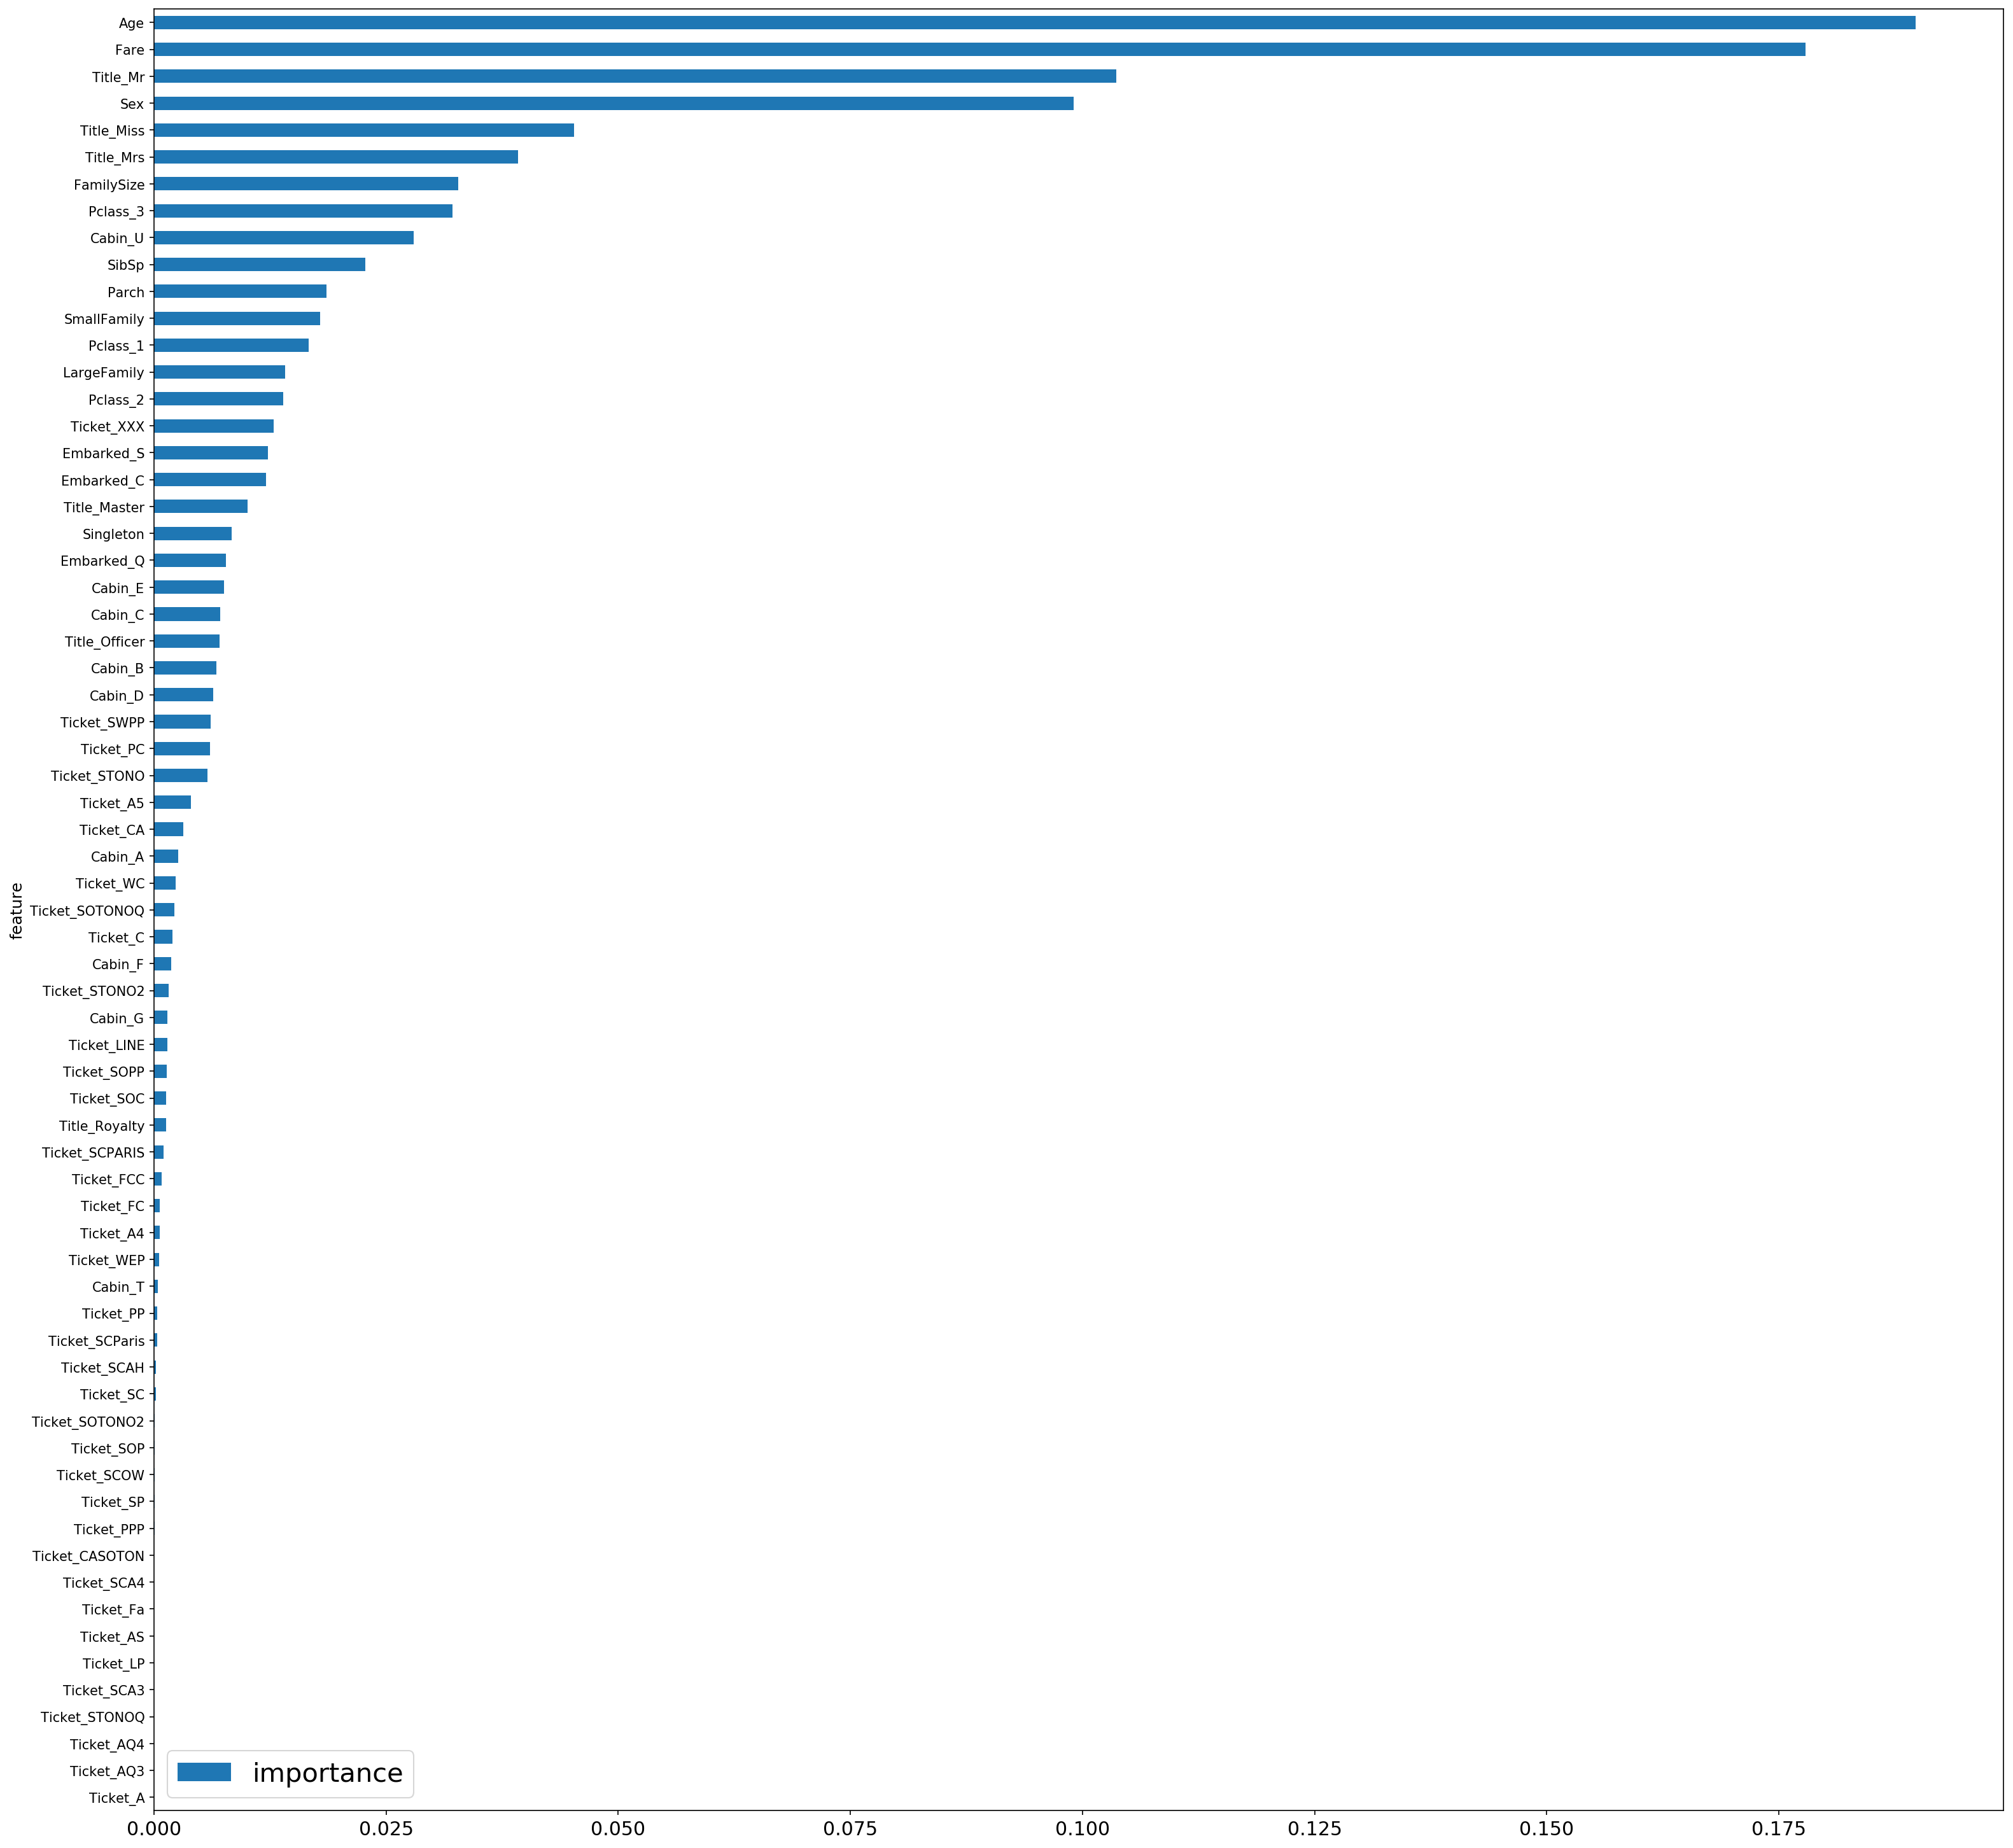

In [80]:
clf = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt')
clf = clf.fit(train, targets)

features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace = True)
features.set_index('feature', inplace = True)


features.plot(kind = 'barh', figsize = (25,25))

Remove less important functions in the training set and test set

In [90]:
model = SelectFromModel(clf, prefit = True)
train_reduced = model.transform(train)
print(train_reduced.shape)

(891, 13)


In [91]:
test_reduced = model.transform(test)
print(test_reduced.shape)

(418, 13)


#### 3.2 Establishing the prediction models

*using logistic Regression, Random Forest and GBoost algorithms*

In [92]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8170536828963796
****
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>
CV score = 0.8226591760299626
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.8193882646691636
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8294132334581772
****


#### 3.3 Hyperparameters adjustment

Optimize the parameters of the model to increase the accuracy of the prediction task.

(This project mainly focuses on the random forest model because of its high interpretability)

In [97]:
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 5, 15],
                 'min_samples_leaf': [1, 5, 15],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=10)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 100, 
                  'min_samples_split': 15, 'max_features': 'sqrt', 'max_depth': 10}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

## 4. Output prediction results

In [99]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('../titanic/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('../titanic/prediction_models.csv', index=False)